In [35]:
### Variables Selection
TYPE_PC = False # True For Mac   -   False Ubuntu
DATASET = "AMZ" # AMZ, HC, PM, UN, TOY
NODE_TYPE = True

In [2]:
import sys

if TYPE_PC:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')
else:
    sys.path.append('/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/05-CommunityDetection/')

import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import auxiliar_path

In [43]:
### Global variables

PATH_DATASET = auxiliar_path.get_path_dataset(DATASET)
PATH_NODETYPE = auxiliar_path.get_path_topbot(NODE_TYPE)

if TYPE_PC:
    GLOBAL_PATH = "/Users/ddiaz/Documents/code/phd-thesis-lab/12-third_year/"    
else:
    GLOBAL_PATH = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/"

# File CSVpa
### GLOBAL variables
GRAPH_PATH = ( GLOBAL_PATH + "00-Data/" + PATH_DATASET + "/02-Graphs/" +
              PATH_NODETYPE + "/" +
              "AMZ_top_master_NC_alpha2.graphml"
              )
# print(GRAPH_PATH)

In [44]:
### Read GRAPH

g = ig.read(GRAPH_PATH)
print(g.summary(), "\n")

print("Graph info:")
print("\t|V| =", g.vcount())
print("\t|E| =", g.ecount())
print("\t d  =", g.density()) 

IGRAPH U-WT 9560 1253277 -- 
+ attr: freq (v), id (v), type (v), weight (e) 

Graph info:
	|V| = 9560
	|E| = 1253277
	 d  = 0.02742879391193473


In [45]:
### Community Detection

comms = g.community_multilevel(weights=g.es["weight"])
g.vs["cls"] = comms.membership
print(comms.summary(), "\n")
comms_with_one = {subgraph.vs["cls"][0]: subgraph for i, subgraph in enumerate(comms.subgraphs()) if len(subgraph.vs) > 5}
comms_to_remove = [sg for sg in comms.subgraphs() if len(sg.vs) <= 5]
nodes_to_remove = []
for i in comms_to_remove:
    for node in i.vs:
        nodes_to_remove.append(node["id"])
len(nodes_to_remove)
asd = []
for node in nodes_to_remove:
    asd.append(g.vs.find(id_eq=node).index)
g.delete_vertices(asd)
print(g.summary())
new_ids_comms = 5000
for com in comms_with_one.values():
    if com.density() > 0.5:        
        new_partition = com.community_multilevel(weights=com.es["weight"])
        for new_comms in new_partition.subgraphs():
            for nodes in new_comms.vs():
                node_to_add = g.vs.find(id_eq=nodes["id"])
                node_to_add["cls"] = new_ids_comms
            new_ids_comms += 1
print("Total Comms", len(set(g.vs["cls"])))

Clustering with 9560 elements and 316 clusters 

IGRAPH U-WT 9189 1253115 -- 
+ attr: cls (v), freq (v), id (v), type (v), weight (e)
Total Comms 39


In [29]:
def internal_external_degree_node(node):
    """Compute the internal degree k_i^int of node i in a community C."""
    node_neighs = node.neighbors()
    node_community = node["cls"]

    internal_degree = [1 for i in node_neighs if i["cls"]==node_community]
    external_degree = [1 for i in node_neighs if i["cls"]!=node_community]
    
    return sum(internal_degree), sum(external_degree)


def check_strong_community(graph, communities):
    """Returns if it is a strong community."""

    dict_to_ret = {}
    otro = {}
    contador_indice = 0

    for id_c in set(g.vs["cls"]):
        flag_weak_comm = False
        porcentaje = 0
        comms = g.vs.select(cls_eq=id_c)
        for node in comms:
            vertex = g.vs.find(id_eq=node["id"])
            int_degree, ext_degree = internal_external_degree_node(vertex)
            if int_degree <= ext_degree:
                flag_weak_comm = True
                porcentaje += 1
        
        if flag_weak_comm:
            dict_to_ret[id_c] = [comms, False, porcentaje/len(comms)]
            otro[str(contador_indice)] = [len(comms), porcentaje/len(comms)]
        else:
            dict_to_ret[id_c] = [comms, True, 0]
            otro[str(contador_indice)] = [len(comms), 0]
        contador_indice += 1
    return dict_to_ret, otro

In [47]:
strongcomms, otro_dato = check_strong_community(g, comms_with_one)
print("Total Comms: ", len(strongcomms))

contador = 0
contador_striong = 0
for porcentaje in strongcomms.values():
    contador += porcentaje[2]
    if porcentaje[1]:
        contador_striong+=1

print("Nodos puente", contador / len(strongcomms))
print("Comunidades strong", contador_striong)
print("Comunidades weak", len(strongcomms)-contador_striong)

Total Comms:  39
Nodos puente 0.449209751092384
Comunidades strong 2
Comunidades weak 37


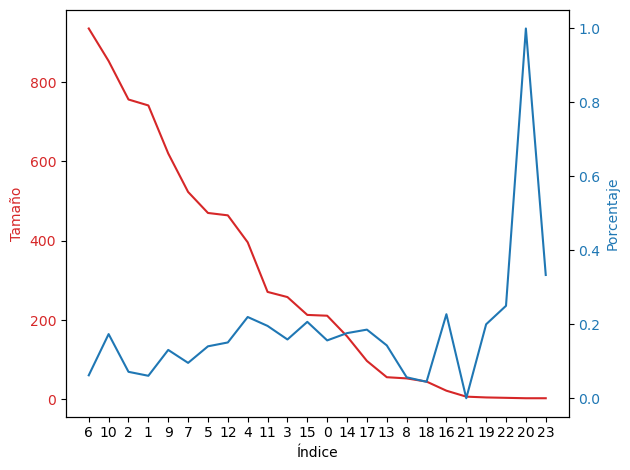

In [ ]:


def generar_grafica_doble_eje_y_ordenada(datos):
    """
    Genera una gráfica con dos ejes Y para visualizar tamaño y porcentaje, ordenada por tamaño.

    Args:
        datos (dict): Diccionario donde las claves son los índices y los valores son listas [tamaño, porcentaje].
    """

    # Ordenar los datos por tamaño de forma descendente
    datos_ordenados = dict(sorted(datos.items(), key=lambda item: item[1][0], reverse=True))

    indices = list(datos_ordenados.keys())
    tamanos = [datos_ordenados[indice][0] for indice in indices]
    porcentajes = [datos_ordenados[indice][1] for indice in indices]

    fig, ax1 = plt.subplots()

    # Eje Y izquierdo para el tamaño
    color = 'tab:red'
    ax1.set_xlabel('Índice')
    ax1.set_ylabel('Tamaño', color=color)
    ax1.plot(indices, tamanos, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Eje Y derecho para el porcentaje
    ax2 = ax1.twinx()  # comparte el mismo eje X
    color = 'tab:blue'
    ax2.set_ylabel('Porcentaje', color=color)
    ax2.plot(indices, porcentajes, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # para evitar que las etiquetas se superpongan
    plt.show()

# Ejemplo de uso
datos_ejemplo = {
    "1": [10, 0.2],
    "2": [15, 0.5],
    "3": [8, 0.8],
    "4": [12, 0.3],
    "5": [20, 0.9]
}

generar_grafica_doble_eje_y_ordenada(otro_dato)

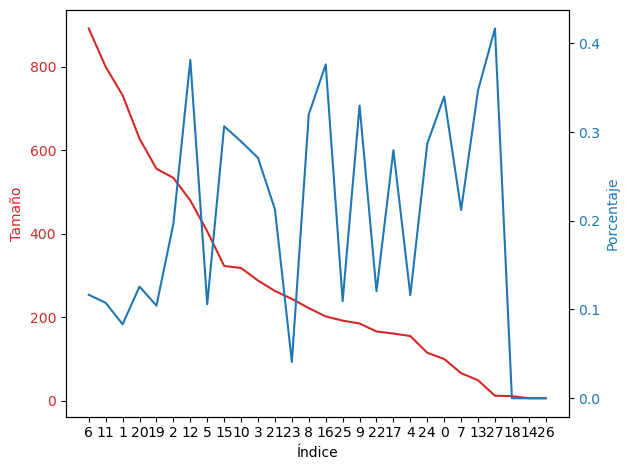

In [42]:
generar_grafica_doble_eje_y_ordenada(otro_dato)

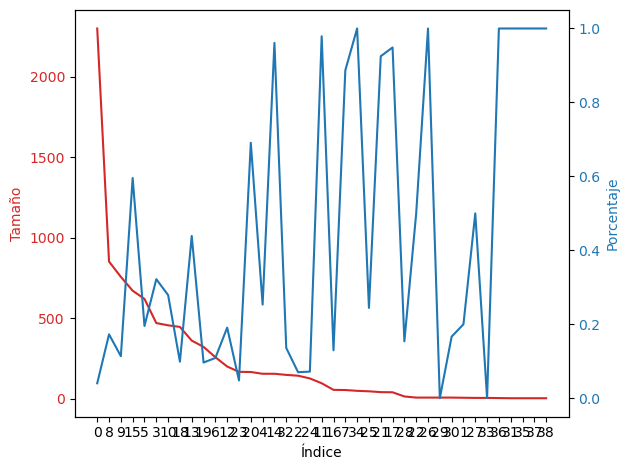

In [48]:
generar_grafica_doble_eje_y_ordenada(otro_dato)